In [104]:
import numpy as np
from common.ffn.ffn_tanh import TanhNet
import matplotlib.pyplot as plt
from common.coeff_calc.coeff_calc_nlo import MCSimulator
from const import *


In [105]:
NN = 1000
'''n0: # dimension of x
    nk: # hidden nodes
    nl: # dimension of y
    l: # number of layers'''
n0,nk,nl,ln=NN,NN,NN,150
'''nd: # number of points in train-set, nd>=2'''
nd = 2

'''experiments_number: # number of experiments'''
experiments_number = 100

#weights distribution variances are set as in (5.139)+(5.142): σ_1=tanh'(0)=1, c^0_w=1/σ_1^2, 
#c^1_w=2/(3*σ_1^2), n_l=NN
cb, cw = 0, 1.0 + (2.0/(NN*3.0))
print(f"cb={cb}, cw={cw}")
#Sub- and super-criticality Cw
cw_super, cw_sub = cw*1.25, cw*0.25


cb=0, cw=1.0006666666666666


In [106]:
#Trainset generation, additional transformation for positive between-points correlation
xx = np.matmul(np.random.normal(loc=1.0, scale=1.0, size=(n0, nd)).astype(np.float32), np.array(([0.5,0.5], [0,1])))
print("Initial covariance between trainpoints 0 and 1:")
print(np.cov(xx[:,0], xx[:,1]))

Initial covariance between trainpoints 0 and 1:
[[0.27277124 0.28117792]
 [0.28117792 1.31720748]]


Theoretical G- and V-values calculation

In [107]:
#--calculate theoretical values, submitted by Zhang Allan--
GG = np.zeros((ln, nd, nd))
KK, KK_inv, GG1 = np.zeros_like(GG), np.zeros_like(GG), np.zeros_like(GG)

VV = np.zeros((ln, nd, nd, nd, nd))
VV_upper = np.zeros_like(VV)

GG[0] = KK[0] = cb + cw * (xx[:, None, :] * xx[:, :, None]).mean(axis=0)
KK_inv[0] = np.linalg.inv(KK[0])
sim = MCSimulator(cb=cb, cw=cw, act=np.tanh, n_samples=1000000)

for idx in range(1, ln):
    nk_2 = n0 if idx <= 2 else nk
    sim.calculate_layer(KK, KK_inv, GG, GG1, VV, VV_upper, nk_2, idx)
    print('-', end='')
 

-----------------------------------------------------------------------------------------------------------------------------------------------------

Experimental G-values

In [108]:
testNet = TanhNet(n0=n0,nk=nk,nl=nl,l=ln)
testNet.set_log_level("info")
testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])
testNet.set_preactivation_recording_indices([1,2])

print('Calculating criticality-experimental values\n')
G00_critic, G01_critic, G11_critic, z0_critic, z1_critic = [], [], [], [], []
yy_critic = np.zeros((experiments_number, nl, nd))
#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw)
    res = testNet.forward(xx)
    yy_critic[experiment_number] = res
    G00_critic.append(testNet.get_gmetric(1,1).copy())
    G11_critic.append(testNet.get_gmetric(2,2).copy())
    G01_critic.append(testNet.get_gmetric(1,2).copy())
    z0_critic.append(testNet.get_preactivation(1).copy())
    z1_critic.append(testNet.get_preactivation(2).copy())
    print('-', end='')

print('\nCalculating subcriticality-experimental values\n')
G00_sub, G01_sub, G11_sub, z0_sub, z1_sub = [], [], [], [], []
yy_sub = np.zeros((experiments_number, nl, nd))
#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw_sub)
    res = testNet.forward(xx)
    yy_sub[experiment_number] = res
    G00_sub.append(testNet.get_gmetric(1,1).copy())
    G11_sub.append(testNet.get_gmetric(2,2).copy())
    G01_sub.append(testNet.get_gmetric(1,2).copy())
    z0_sub.append(testNet.get_preactivation(1).copy())
    z1_sub.append(testNet.get_preactivation(2).copy())
    print('-', end='')

print('\nCalculating supercriticality-experimental values\n')
G00_super, G01_super, G11_super, z0_super, z1_super = [], [], [], [], []
yy_sub = np.zeros((experiments_number, nl, nd))
#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw_super)
    res = testNet.forward(xx)
    yy_sub[experiment_number] = res
    G00_super.append(testNet.get_gmetric(1,1).copy())
    G11_super.append(testNet.get_gmetric(2,2).copy())
    G01_super.append(testNet.get_gmetric(1,2).copy())
    z0_super.append(testNet.get_preactivation(1).copy())
    z1_super.append(testNet.get_preactivation(2).copy())
    print('-', end='')


FeedForwardNet created with n0=1000, nk=1000, nl=1000, l=150, bias_on=False
Calculating criticality-experimental values

----------------------------------------------------------------------------------------------------
Calculating subcriticality-experimental values

----------------------------------------------------------------------------------------------------
Calculating supercriticality-experimental values

----------------------------------------------------------------------------------------------------

Experimental preactivation covariance (should coinside with experimental G-metric)

In [109]:
cord_x = np.arange(0, ln)

def calc_sample_variance(z0_data, z1_data):
    G00_sample, G11_sample, G01_sample = [],[],[]
    for idx1 in cord_x:
        z0_buff, z1_buff = [], []
        for idx2 in range(len(z0_critic)):
            z0_buff.append(z0_data[idx2][idx1])
            z1_buff.append(z1_data[idx2][idx1])
        z0buff = np.asarray(z0_buff).flatten()
        z1buff = np.asarray(z1_buff).flatten()
        cov_buff = np.cov(z0buff, z1buff)
        G00_sample.append(cov_buff[0,0])
        G11_sample.append(cov_buff[1,1])
        G01_sample.append(cov_buff[0,1])
    return G00_sample, G11_sample, G01_sample

S00_critic, S11_critic, S01_critic = calc_sample_variance(z0_critic, z1_critic)
S00_sub, S11_sub, S01_sub = calc_sample_variance(z0_sub, z1_sub)
S00_super, S11_super, S01_super = calc_sample_variance(z0_super, z1_super)


Experimental V-values

In [110]:
G00critic = np.asarray(G00_critic)
G11critic = np.asarray(G11_critic)
V0000_critic, V1111_critic, V0011_critic = np.zeros((ln)), np.zeros((ln)), np.zeros((ln))

for ii in cord_x:
    covMatrix = np.cov(G00critic[:,ii], G11critic[:,ii])
    if ii == 0:
        V0000_critic[0], V1111_critic[0], V0011_critic[0] = n0*covMatrix[0,0], n0*covMatrix[1,1], n0*covMatrix[0,1]
    else:
        V0000_critic[ii], V1111_critic[ii], V0011_critic[ii] = nk*covMatrix[0,0], nk*covMatrix[1,1], nk*covMatrix[0,1]

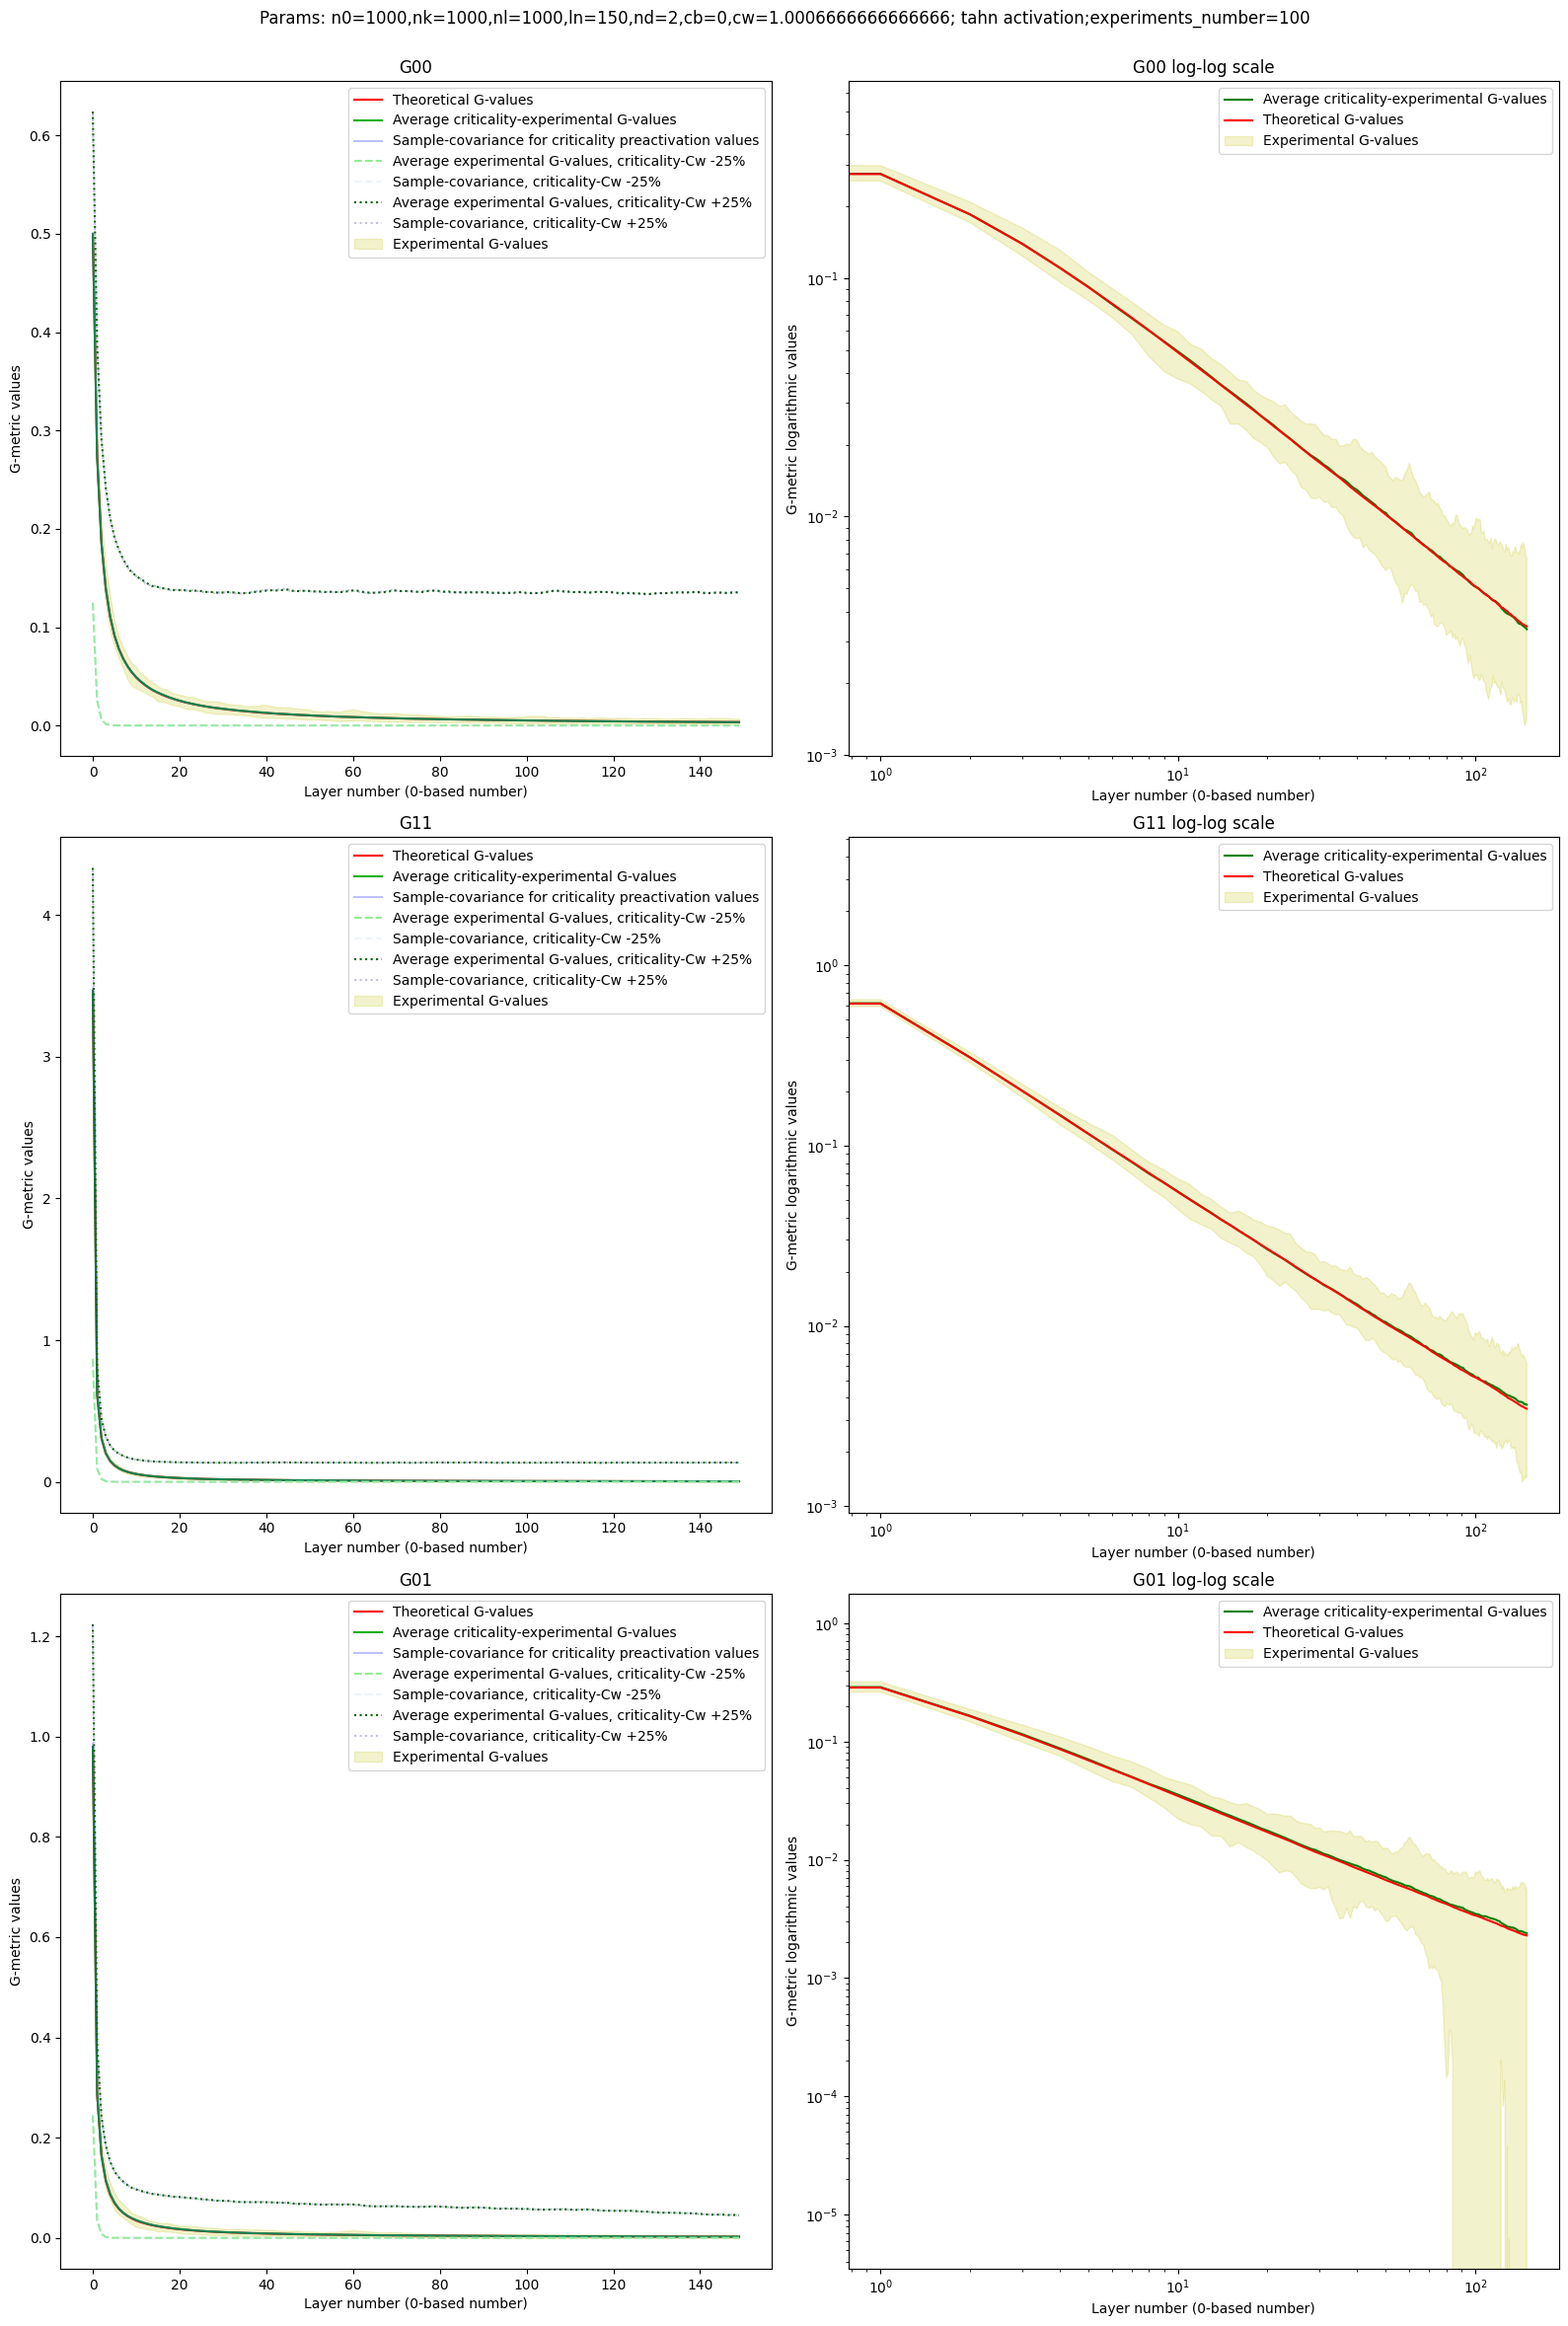

In [111]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 24))

G00_max, G00_min, G00_avg = np.max(G00_critic, axis=0), np.min(G00_critic, axis=0), np.average(G00_critic, axis=0)
G00_sub_avg, G00_super_avg = np.average(G00_sub, axis=0), np.average(G00_super, axis=0)

ax1.plot(GG[:,0,0], color='r', label=theor_g)
ax1.plot(G00_avg, color='xkcd:green', label=avex_g)
ax1.plot(S00_critic, color='b', alpha=0.25, label=samplecov_z)
ax1.plot(G00_sub_avg, color='lightgreen', ls='dashed', label="Average experimental G-values, criticality-Cw -25%")
ax1.plot(S00_sub, color='lightblue', ls='dashed', alpha=0.25, label="Sample-covariance, criticality-Cw -25%")
ax1.plot(G00_super_avg, color='darkgreen', ls='dotted', label="Average experimental G-values, criticality-Cw +25%")
ax1.plot(S00_super, color='darkblue', ls='dotted', alpha=0.25, label="Sample-covariance, criticality-Cw +25%")
ax1.fill_between(x=cord_x, y1=G00_min, y2=G00_max, color='y', alpha=.2, label=ex_g)
ax1.set_xlabel(layernum)
ax1.set_ylabel(values_g)
ax1.legend()
ax1.title.set_text("G00")

ax2.plot((G00_avg), color='g', label=avex_g)
ax2.plot(GG[:,0,0], color='r', label=theor_g)
ax2.fill_between(x=cord_x, y1=(G00_min), y2=(G00_max), color='y', alpha=.2, label=ex_g)
ax2.set_xlabel(layernum)
ax2.set_ylabel(valueslog_g)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()
ax2.title.set_text("G00 log-log scale")

if (nd > 1):
    G11_max, G11_min, G11_avg = np.max(G11_critic, axis=0), np.min(G11_critic, axis=0), np.average(G11_critic, axis=0)
    G11_sub_avg, G11_super_avg = np.average(G11_sub, axis=0), np.average(G11_super, axis=0)

    ax3.plot(GG[:,1,1], color='r', label=theor_g)
    ax3.plot(G11_avg, color='xkcd:green', label=avex_g)
    ax3.plot(S11_critic, color='b', alpha=0.25, label=samplecov_z)
    ax3.plot(G11_sub_avg, color='lightgreen', ls='dashed', label="Average experimental G-values, criticality-Cw -25%")
    ax3.plot(S11_sub, color='lightblue', ls='dashed', alpha=0.25, label="Sample-covariance, criticality-Cw -25%")
    ax3.plot(G11_super_avg, color='darkgreen', ls='dotted', label="Average experimental G-values, criticality-Cw +25%")
    ax3.plot(S11_super, color='darkblue', ls='dotted', alpha=0.25, label="Sample-covariance, criticality-Cw +25%")
    ax3.fill_between(x=cord_x, y1=G11_min, y2=G11_max, color='y', alpha=.2, label=ex_g)
    ax3.set_xlabel(layernum)
    ax3.set_ylabel(values_g)
    ax3.legend()
    ax3.title.set_text("G11")

    ax4.plot((G11_avg), color='g', label=avex_g)
    ax4.plot(GG[:,1,1], color='r', label=theor_g)
    ax4.fill_between(x=cord_x, y1=(G11_min), y2=(G11_max), color='y', alpha=.2, label=ex_g)
    ax4.set_xlabel(layernum)
    ax4.set_ylabel(valueslog_g)
    ax4.set_xscale("log")
    ax4.set_yscale("log")
    ax4.legend()
    ax4.title.set_text("G11 log-log scale")

    G01_max, G01_min, G01_avg = np.max(G01_critic, axis=0), np.min(G01_critic, axis=0), np.average(G01_critic, axis=0)
    G01_sub_avg, G01_super_avg = np.average(G01_sub, axis=0), np.average(G01_super, axis=0)

    ax5.plot(GG[:,0,1], color='r', label=theor_g)
    ax5.plot(G01_avg, color='xkcd:green', label=avex_g)
    ax5.plot(S01_critic, color='b', alpha=0.25, label=samplecov_z)
    ax5.plot(G01_sub_avg, color='lightgreen', ls='dashed', label="Average experimental G-values, criticality-Cw -25%")
    ax5.plot(S01_sub, color='lightblue', ls='dashed', alpha=0.25, label="Sample-covariance, criticality-Cw -25%")
    ax5.plot(G01_super_avg, color='darkgreen', ls='dotted', label="Average experimental G-values, criticality-Cw +25%")
    ax5.plot(S01_super, color='darkblue', ls='dotted', alpha=0.25, label="Sample-covariance, criticality-Cw +25%")
    ax5.fill_between(x=cord_x, y1=G01_min, y2=G01_max, color='y', alpha=.2, label=ex_g)
    ax5.set_xlabel(layernum)
    ax5.set_ylabel(values_g)
    ax5.legend()
    ax5.title.set_text("G01")

    ax6.plot((G01_avg), color='g', label=avex_g)
    ax6.plot(GG[:,0,1], color='r', label=theor_g)
    ax6.fill_between(x=cord_x, y1=(G01_min), y2=(G01_max), color='y', alpha=.2, label=ex_g)
    ax6.set_xlabel(layernum)
    ax6.set_ylabel(valueslog_g)
    ax6.set_xscale("log")
    ax6.set_yscale("log")
    ax6.legend()
    ax6.title.set_text("G01 log-log scale")

fig.tight_layout()
fig.subplots_adjust(top=0.95)
dummy=fig.suptitle(f"Params: n0={n0},nk={nk},nl={nl},ln={ln},nd={nd},cb={cb},cw={cw}; \
tahn activation;experiments_number={experiments_number}")

In $G_{00}$ and $G_{11}$ there is an experimental dependency $G_{XX}^{(l)} = const / l^{1.2}$ approximately, i.e it's not exponential but polynomial decay.
This result approximately coincides with formula (5.94).

Text(0.5, 1.0, 'G-values decays like (1/layer)**1.2 in log-log scale')

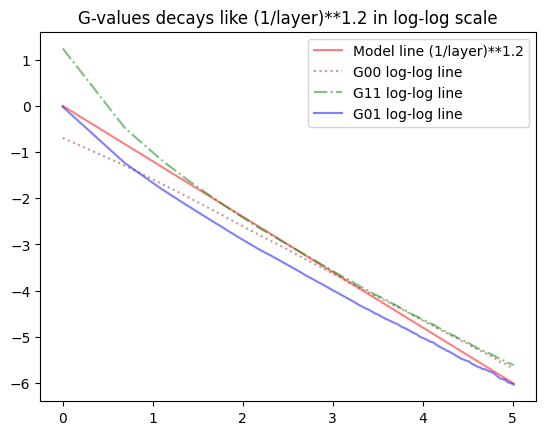

In [112]:
model_values = np.power((np.arange(ln)+1), -1.2)
xx = np.log(np.arange(ln)+1)
#zzzz = 1/np.exp((np.arange(20)+1))
plt.plot(xx, np.log(model_values), color='r', alpha=0.5, label='Model line (1/layer)**1.2')
plt.plot(xx, np.log(np.abs(G00_avg)), color='brown', ls='dotted', alpha=0.5, label='G00 log-log line')
plt.plot(xx, np.log(np.abs(G11_avg)), color='g', ls='dashdot', alpha=0.5, label='G11 log-log line')
plt.plot(xx, np.log(np.abs(G01_avg)), color='b', alpha=0.5, label='G01 log-log line')
plt.legend()
plt.title("G-values decays like (1/layer)**1.2 in log-log scale")

V-value graphs

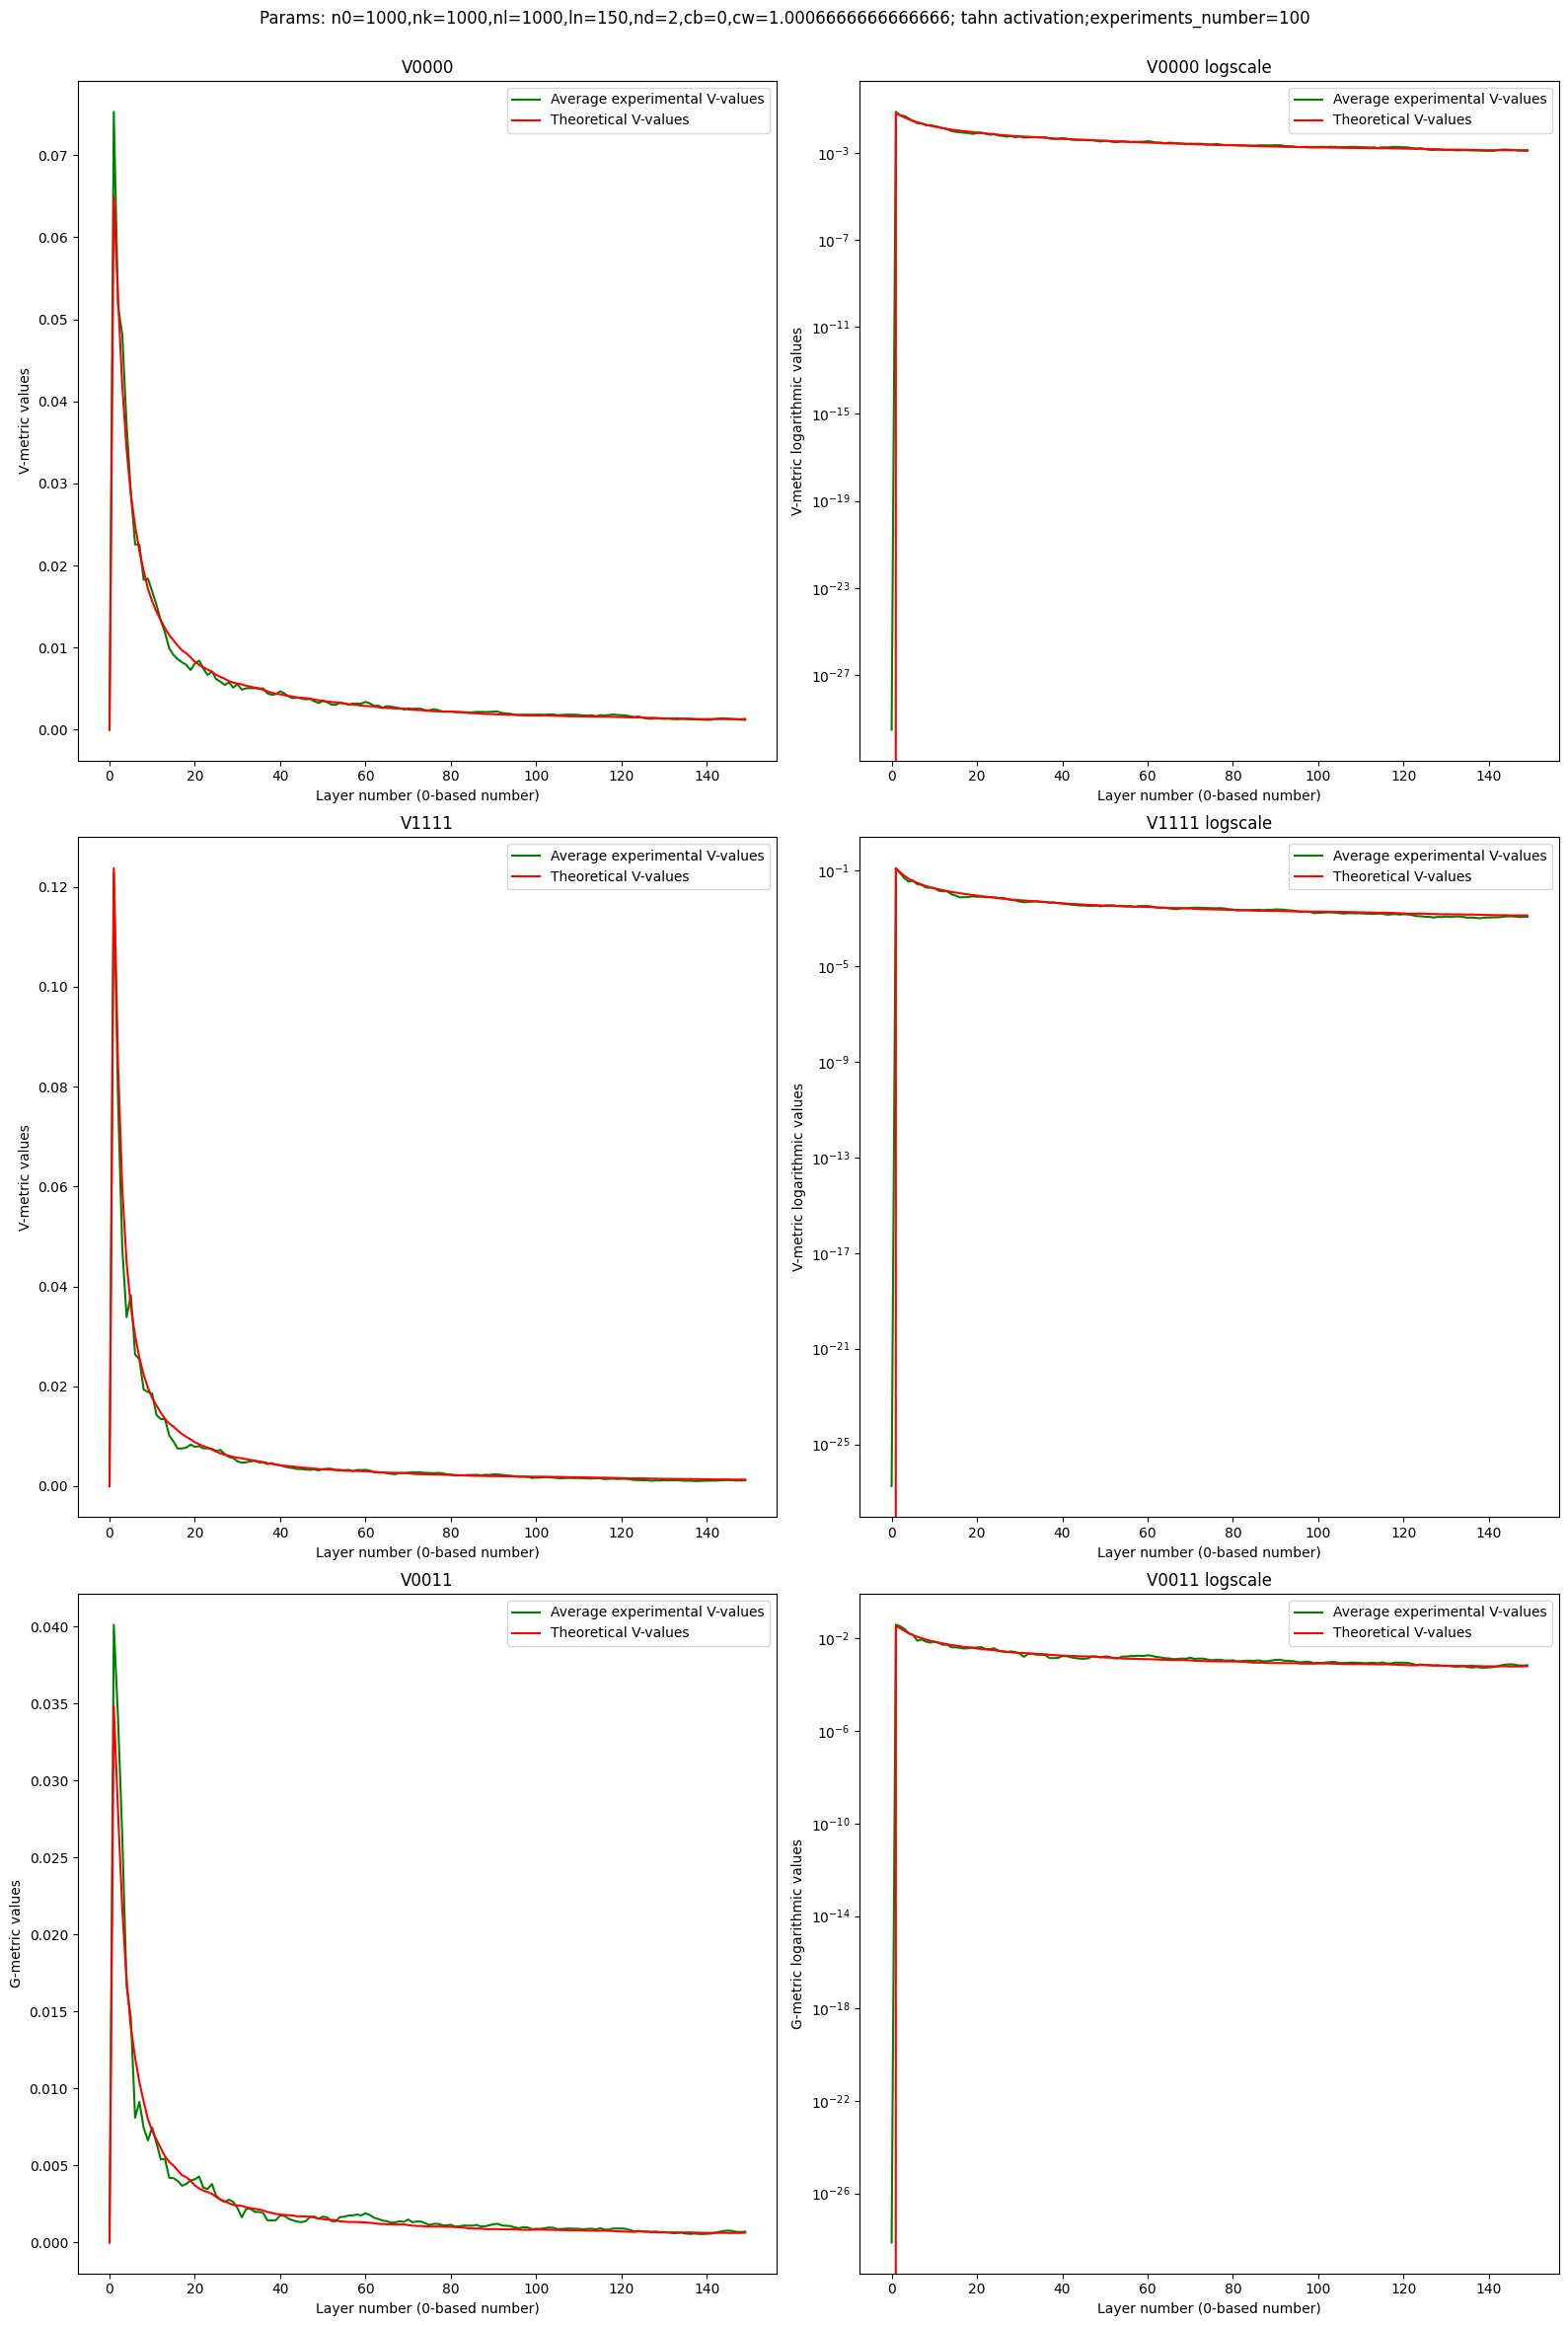

In [113]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 24))

#V0000, V1111, V0011
ax1.plot(V0000_critic, color='g', label=avex_v)
ax1.plot(VV[:,0,0,0,0], color='r', label=theor_v)
ax1.set_xlabel(layernum)
ax1.set_ylabel(values_v)
ax1.legend()
ax1.title.set_text("V0000")

ax2.plot(V0000_critic, color='g', label=avex_v)
ax2.plot(VV[:,0,0,0,0], color='r', label=theor_v)
ax2.set_xlabel(layernum)
ax2.set_ylabel(valueslog_v)
ax2.set_yscale("log")
ax2.legend()
ax2.title.set_text("V0000 logscale")

if (nd > 1):
    ax3.plot(V1111_critic, color='g', label=avex_v)
    ax3.plot(VV[:,1,1,1,1], color='r', label=theor_v)
    ax3.set_xlabel(layernum)
    ax3.set_ylabel(values_v)
    ax3.legend()
    ax3.title.set_text("V1111")

    ax4.plot(V1111_critic, color='g', label=avex_v)
    ax4.plot(VV[:,1,1,1,1], color='r', label=theor_v)
    ax4.set_xlabel(layernum)
    ax4.set_ylabel(valueslog_v)
    ax4.set_yscale("log")
    ax4.legend()
    ax4.title.set_text("V1111 logscale")

    ax5.plot(V0011_critic, color='g', label=avex_v)
    ax5.plot(VV[:,0,0,1,1], color='r', label=theor_v)
    ax5.set_xlabel(layernum)
    ax5.set_ylabel(values_g)
    ax5.legend()
    ax5.title.set_text("V0011")

    ax6.plot(V0011_critic, color='g', label=avex_v)
    ax6.plot(VV[:,0,0,1,1], color='r', label=theor_v)
    ax6.set_xlabel(layernum)
    ax6.set_ylabel(valueslog_g)
    ax6.set_yscale("log")
    ax6.legend()
    ax6.title.set_text("V0011 logscale")

fig.tight_layout()
fig.subplots_adjust(top=0.95)
dummy=fig.suptitle(f"Params: n0={n0},nk={nk},nl={nl},ln={ln},nd={nd},cb={cb},cw={cw}; \
tahn activation;experiments_number={experiments_number}")